In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


#### import data

In [2]:
data=pd.read_csv('./data/samsung.csv')
data=data.dropna().reset_index()
print(data.shape)
data.head()

(721, 8)


,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-01-17,36580.0,37460.0,36580.0,36960.0,7811.878418,8150700.0
1,1,2017-01-18,37040.0,37500.0,36620.0,36940.0,7807.651367,8875400.0
2,2,2017-01-19,37720.0,37920.0,37020.0,37480.0,7921.786133,9418900.0
3,3,2017-01-20,37120.0,37420.0,36880.0,37200.0,7862.604004,9185000.0
4,4,2017-01-23,37200.0,38060.0,37000.0,38060.0,8044.374512,8810400.0


#### data frame 만들기

In [3]:
class sumin():
    
    def __init__(self):
        self.data = data

    @staticmethod
    def bollinger_band(data, w=20, k=2):

        data=data['Close']
        mbb = data.rolling(w).mean()
        ubb = mbb + k * data.rolling(w).std()
        lbb = mbb - k * data.rolling(w).std()
        result = np.array([data,mbb,ubb,lbb])

        df = pd.DataFrame(result).T
        df.columns = ["close", "mbb", "ubb", "lbb"]

        return df
    
    
    @staticmethod
    def moving_average(data, w=5):
        
        data=data['Close']
        ma_w=data.ewm(span=w).mean()
        ma_5=data.ewm(span=5).mean()
        ma_10=data.ewm(span=10).mean()
        ma_15=data.ewm(span=15).mean()
        ma_20=data.ewm(span=20).mean()
        ma_30=data.ewm(span=30).mean()
        ma_60=data.ewm(span=60).mean()

        result = np.array([data,ma_w,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60])

        df = pd.DataFrame(result).T
        df.columns = ["close", "user_ma_{}".format(w), "ma_5", "ma_10","ma_15","ma_20","ma_30","ma_60" ]

        if w == 5:
            del df['user_ma_5']

        return df
    
    
    @staticmethod
    def macd(data, fast=12, slow=26, signal=9) :

        data=data['Close']
        fast = data.ewm(span=fast).mean() 
        slow = data.ewm(span=slow).mean() 
        macd = fast - slow 
        signal = macd.ewm(span=signal).mean() 
        osc = macd - signal 

        result = np.array([data,macd,fast,slow, signal,osc])
        df = pd.DataFrame(result).T
        df.columns = ["close", "macd", "fast", "slow","signal","osc"]

        return df
    
    @staticmethod
    def rsi(data, length=14):

        data=data['Close']
        delta = data.diff()
        delta = delta[1:]
        up, down = delta.copy(), delta.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        roll_up1 = up.ewm(com=(length-1), min_periods=length).mean()
        roll_down1 = down.abs().ewm(com=(length-1), min_periods=length).mean()

        RSI_1 = roll_up1 / roll_down1
        RSI = 100.0 - (100.0 / (1.0 + RSI_1))

        df = pd.DataFrame([data,RSI]).T
        df.columns = ["close", "rsi"]

        return df
    
    
    @staticmethod
    def stochastic(data, n=15, m=5, t=3):

        high = data.High.rolling(window=n, min_periods=1).max()
        low = data.Low.rolling(window=n, min_periods=1).min()

        fast_K = ((data.Close - low) / (high - low))*100
        fast_D = fast_K.ewm(span=m).mean()
        Slow_D = fast_D.ewm(span=t).mean()

        df = pd.DataFrame([data['Close'],data['Open'],data['High'],data['Low'],fast_K,fast_D,Slow_D]).T
        df.columns = ["close",'open','high','low', "fast_K",'fast_D','slow_D']

        return df

    @staticmethod
    def roc(data,n=5):
        
        N = data['Close'].diff(n)
        D = data['Close'].shift(n)
        ROC = pd.Series(N/D,name='ROC')

        df = pd.DataFrame([data['Close'],ROC]).T
        df.columns = ["close", "roc"]
        
        return df

In [4]:
sumin=sumin()
bb=sumin.bollinger_band(data)
ma=sumin.moving_average(data)
macd=sumin.macd(data)
rsi=sumin.rsi(data)
sto=sumin.stochastic(data)
roc=sumin.roc(data)

In [5]:
bb.shape, ma.shape, macd.shape, rsi.shape, sto.shape, roc.shape

((721, 4), (721, 7), (721, 6), (721, 2), (721, 7), (721, 2))

In [6]:
data_1=pd.merge(bb,ma, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,macd, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,rsi, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,sto, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,roc, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1, data["Close"], how='outer', left_index=True, right_index=True)

#include date
df=pd.merge(data_1, data['Date'],left_on=None, right_on=None, left_index=True, right_index=True)

In [7]:
df = df[['Date','Close','mbb','ubb','lbb','ma_5','ma_10','ma_15','ma_20','ma_30','ma_60','macd','fast','slow','signal',
                   'osc','rsi','open','high','low','fast_K','fast_D','slow_D','roc']]

In [8]:
df=df.dropna()

In [9]:
print(df.shape)
df.head()

(702, 24)


,Date,Close,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
19,2017-02-15,37720.0,38415.0,40275.927895,36554.072105,37990.698549,38280.522555,38384.153558,38422.070516,38443.055695,...,43.756182,-147.316867,44.042066,37080.0,37960.0,37080.0,21.917808,34.048228,41.371132,-0.017708
20,2017-02-16,38020.0,38468.0,40211.095854,36724.904146,38000.467658,38232.443934,38335.700138,38378.445246,38406.834335,...,11.741611,-126.581872,48.808410,37800.0,38360.0,37780.0,32.191781,33.429288,37.400208,-0.009896
21,2017-02-17,37860.0,38514.0,40131.332437,36896.667563,37953.638846,38163.897615,38272.910527,38322.929469,38360.982816,...,-17.409180,-115.527689,46.531958,37560.0,38040.0,37280.0,26.712329,31.190003,34.295105,-0.013034
22,2017-02-20,38660.0,38573.0,40115.889975,37030.110025,38189.113546,38254.999775,38323.649182,38358.600947,38385.579585,...,-32.223851,-58.821431,57.264594,38220.0,38780.0,38160.0,56.028369,39.470196,36.882650,0.018440
23,2017-02-21,38940.0,38660.0,40067.169612,37252.830388,38439.423900,38380.562116,38403.950782,38419.484461,38430.390436,...,-33.421788,-4.763464,60.270516,38540.0,39560.0,38420.0,72.093023,50.345118,43.613884,0.036189


#### 상관관계 확인후 변수 줄이기

In [10]:
df[['Close','mbb','ma_5','ma_60','macd','fast','osc','rsi','fast_K','slow_D','roc']].corr()
df=df[['Close','ma_60','macd','fast','osc','rsi','fast_K','slow_D','roc']]

#### dataframe 정규화 시키기

In [11]:
df_without_date = df[df.columns]
sc = MinMaxScaler()
df_scale_without_date = sc.fit_transform(df_without_date)

In [12]:
# 날짜 제거한 데이터 프레임 생성
df_scale_without_date = pd.DataFrame(df_scale_without_date, columns=df.columns)
df_scale_without_date.columns=[i for i in df.columns]

In [13]:
print(df_scale_without_date.shape)
df_scale_without_date.head()

(702, 9)


,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc
0,0.011368,0.003998,0.358005,0.005728,0.418849,0.338202,0.219178,0.380315,0.378231
1,0.024000,0.002239,0.354439,0.003283,0.434135,0.426595,0.321918,0.335974,0.417894
2,0.017263,0.000000,0.348717,0.000000,0.442284,0.384378,0.267123,0.301301,0.401960
3,0.050947,0.001100,0.361962,0.003398,0.484089,0.583417,0.560284,0.330194,0.561755
4,0.062737,0.003172,0.378676,0.008398,0.523942,0.639163,0.720930,0.405358,0.651865


#### y값 추가하여 정규화 시킨 이후 상관계수 확인

In [14]:
y = data[["Close"]]
y = y[29:]

# data start 2017-02-15 original index 19
# so y have to start after 10day. index is 29

sc_y=MinMaxScaler()
y_scale = sc.fit_transform(y)
y_scale =pd.DataFrame(y_scale)

In [15]:
df_inclue_y=pd.concat([df_scale_without_date, y_scale], axis=1).dropna()

In [16]:
df_inclue_y.head()

,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc,0
0,0.011368,0.003998,0.358005,0.005728,0.418849,0.338202,0.219178,0.380315,0.378231,0.095579
1,0.024000,0.002239,0.354439,0.003283,0.434135,0.426595,0.321918,0.335974,0.417894,0.091368
2,0.017263,0.000000,0.348717,0.000000,0.442284,0.384378,0.267123,0.301301,0.401960,0.110737
3,0.050947,0.001100,0.361962,0.003398,0.484089,0.583417,0.560284,0.330194,0.561755,0.115789
4,0.062737,0.003172,0.378676,0.008398,0.523942,0.639163,0.720930,0.405358,0.651865,0.115789


In [17]:
df_inclue_y.corr()

,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc,0
Close,1.000000,0.822392,0.455316,0.960371,0.142409,0.370267,0.282000,0.324941,0.194795,0.843904
ma_60,0.822392,1.000000,-0.082903,0.908517,-0.157693,-0.180613,-0.165783,-0.149578,-0.137554,0.691208
macd,0.455316,-0.082903,1.000000,0.313415,0.401214,0.822563,0.589881,0.825218,0.296624,0.383884
fast,0.960371,0.908517,0.313415,1.000000,-0.087129,0.126018,0.029927,0.136490,-0.050669,0.814407
osc,0.142409,-0.157693,0.401214,-0.087129,1.000000,0.704609,0.792074,0.740474,0.696044,0.123178
rsi,0.370267,-0.180613,0.822563,0.126018,0.704609,1.000000,0.884532,0.859089,0.696898,0.298426
fast_K,0.282000,-0.165783,0.589881,0.029927,0.792074,0.884532,1.000000,0.813673,0.755110,0.232928
slow_D,0.324941,-0.149578,0.825218,0.136490,0.740474,0.859089,0.813673,1.000000,0.465686,0.267960
roc,0.194795,-0.137554,0.296624,-0.050669,0.696044,0.696898,0.755110,0.465686,1.000000,0.138689
0,0.843904,0.691208,0.383884,0.814407,0.123178,0.298426,0.232928,0.267960,0.138689,1.000000


#### PCA분석

In [18]:
cov_mat = np.cov(df_scale_without_date.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[2.82380291e-01 1.16184301e-01 4.16155315e-02 1.63819400e-02
 9.25667086e-03 3.20857833e-03 4.57654311e-05 2.57504029e-04
 1.52743983e-03]


In [19]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]

In [20]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.59971431, 0.84646448, 0.93484682, 0.96963849, 0.98929765,
       0.99611197, 0.99935592, 0.9999028 , 1.        ])

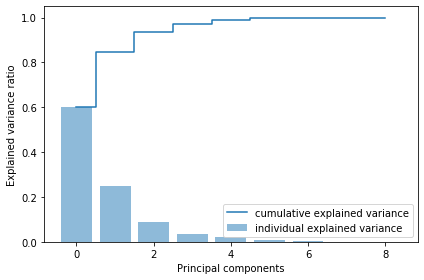

In [21]:
%matplotlib inline

plt.bar(range(0,9), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(0,9), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##### 에이겐 쌍을 이용하여 투영행렬 생성 

In [22]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True) 
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14828223  0.47396878]
 [-0.02853746  0.63608203]
 [ 0.35254312  0.12021985]
 [ 0.07746627  0.56700599]
 [ 0.27321945 -0.10808268]
 [ 0.39649068 -0.02055701]
 [ 0.5524713  -0.12332566]
 [ 0.50303537 -0.02569497]
 [ 0.23830124 -0.08264826]]


##### 투영행렬로 피처 압축

In [23]:
df_scale_without_date_std = StandardScaler().fit_transform(df_scale_without_date)

In [24]:
df_scale_without_date_std[0].dot(w) 
df_pca = df_scale_without_date_std.dot(w) 

In [25]:
df_pca=pd.DataFrame(df_pca)
df_pca.columns=['pca1','pca2']
df_pca.head()

,pca1,pca2
0,-2.017478,-3.466404
1,-1.674871,-3.519042
2,-1.933046,-3.524290
3,-0.682654,-3.650695
4,0.049125,-3.730955


In [26]:
len(df_pca), type(df_pca)

(702, pandas.core.frame.DataFrame)

In [27]:
df_pca.describe()

,pca1,pca2
count,7.020000e+02,7.020000e+02
mean,1.322146e-16,6.730925e-16
std,2.124132e+00,1.664236e+00
min,-4.183782e+00,-3.758633e+00
25%,-1.850664e+00,-1.061527e+00
50%,8.930527e-02,-1.507623e-01
75%,1.832960e+00,1.321228e+00
max,4.365691e+00,4.431995e+00


In [28]:
df_pca

,pca1,pca2
0,-2.017478,-3.466404
1,-1.674871,-3.519042
2,-1.933046,-3.524290
3,-0.682654,-3.650695
4,0.049125,-3.730955
...,...,...
697,4.352076,3.697701
698,4.167334,3.880966
699,3.198174,4.030648
700,3.985917,4.223382


#### pca로 만든 데이터 프레임을 5일씩 묶어주기

In [29]:
d_matrix=df_pca[['pca1','pca2']].as_matrix()

p_result =[]
for i in range(len(df_pca)-10):
    for j in range(5):
        p_result.append(d_matrix[i+j])

C:\Users\wsm26\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [30]:
p_result=np.array(p_result)
p_result=p_result.reshape((len(d_matrix)-10,5,-1))

In [31]:
p_result[0]

array([[-2.01747843, -3.46640414],
       [-1.67487052, -3.51904234],
       [-1.93304638, -3.52429011],
       [-0.68265354, -3.6506953 ],
       [ 0.04912526, -3.73095493]])

In [32]:
p_result.shape, y_scale.shape

((692, 5, 2), (692, 1))

#### trian, text set 나눠주기

In [33]:
X_train,X_test = p_result[:int(len(p_result)*0.9)],p_result[int(len(p_result)*0.9):]
y_train,y_test = y_scale[:int(len(p_result)*0.9)], y_scale[int(len(p_result)*0.9):]

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((622, 5, 2), (70, 5, 2), (622, 1), (70, 1))

#### 모델 만들기

In [35]:
model = Sequential()

model.add(LSTM(units=100, input_shape=(5,2)))
model.add(Dense(units=1))

model.add(Dropout(0.1))

early_stopping = EarlyStopping(patience=30)

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.3, callbacks=[early_stopping])

Train on 435 samples, validate on 187 samples
Epoch 1/300
435/435 [==============================] - 1s 1ms/step - loss: 0.0945 - val_loss: 0.0367
Epoch 2/300
435/435 [==============================] - 0s 186us/step - loss: 0.0435 - val_loss: 0.0277
Epoch 3/300
435/435 [==============================] - 0s 292us/step - loss: 0.0456 - val_loss: 0.0169
Epoch 4/300
435/435 [==============================] - 0s 395us/step - loss: 0.0362 - val_loss: 0.0124
Epoch 5/300
435/435 [==============================] - 0s 232us/step - loss: 0.0327 - val_loss: 0.0076
Epoch 6/300
435/435 [==============================] - 0s 209us/step - loss: 0.0314 - val_loss: 0.0092
Epoch 7/300
435/435 [==============================] - 0s 246us/step - loss: 0.0341 - val_loss: 0.0052
Epoch 8/300
435/435 [==============================] - 0s 441us/step - loss: 0.0306 - val_loss: 0.0074
Epoch 9/300
435/435 [==============================] - 0s 324us/step - loss: 0.0248 - val_loss: 0.0047
Epoch 10/300
435/435 [=======

#### prediction

In [36]:
predicted = model.predict(X_test)

In [37]:
len(y_test), type(y_test) , len(predicted), type(predicted)

(70, pandas.core.frame.DataFrame, 70, numpy.ndarray)

In [38]:
y_test=np.array(y_test)

#### accuracy

In [39]:
RMSE = mean_squared_error(y_test, predicted)**0.5    
print("RMSE =",RMSE)
error = y_test-predicted
print("STD = ", np.std(error))

RMSE = 0.1691978670334448
STD =  0.09965132259537643


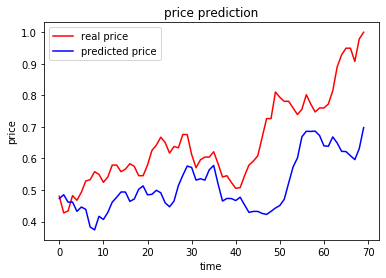

In [40]:
plt.plot(y_test, color="red", label="real price")
plt.plot(predicted, color="blue", label="predicted price")
plt.title("price prediction")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()